## StackLabs - Health Cross Sell

### Análise Exploratória de Dados

In [2]:
import pandas as pd
import datetime
import glob
import numpy as np
import sidetable as stb
from minio import Minio
import seaborn as sns
import warnings
import sweetviz as sv
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [3]:
# Função para converter o tipo de dado para categórico
def conv_cat(df,cols):
    df[cols]=df[cols].astype('category')

In [5]:
data = pd.read_csv('train.csv')
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


#### Organizando o dataset

In [6]:
data = data[['id','Gender','Vehicle_Age','Vehicle_Damage','Region_Code','Policy_Sales_Channel','Driving_License','Previously_Insured',
          'Age','Vintage','Annual_Premium','Response']]

#### Descrição dos dados

In [7]:
desc       = ["ID unico para o cliente.",
              "Sexo do cliente.",
              "Idade do Veiculo.",
              "1 : Cliente ja teve veiculo danificado no passado. 0 : Cliente não teve veiculo danificado no passado.",
              "Codigo unico da regiao do cliente.",
              "Código para o canal de divulgação ao cliente ou seja. Agentes diferentes, por correio, por telefone, etc..",
              "0: não tem habilitacao, 1: tem habilitacao.",
              "1 : Cliente já possui seguro, 0 : Cliente não possui seguro.",
              "Idade do cliente.",
              "Número de dias, o cliente foi associado à empresa.",    
              "O valor que o cliente precisa pagar como taxa no ano.",                          
              "1 : Cliente esta interessado, 0 : Cliente não esta interessado"]

data_desc = []
j = 0
for column in data.columns:
  data_desc.append(
      [
       column,
       data[column].dtypes,
       data[column].isnull().sum(),
       round(data[column].isnull().sum()/len(data)*100, 2),
       data[column].nunique(),
       data[column].unique(),
       desc[j]
       ]
       )
  j += 1

df = pd.DataFrame(data_desc, columns = ['Coluna', 'Dtype', 'Null', 'Null (%)', 'Nunique', 'Unique','Descrição'])
df

,Coluna,Dtype,Null,Null (%),Nunique,Unique,Descrição
0,id,int64,0,0.0,381109,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ID unico para o cliente.
1,Gender,object,0,0.0,2,"[Male, Female]",Sexo do cliente.
2,Vehicle_Age,object,0,0.0,3,"[> 2 Years, 1-2 Year, < 1 Year]",Idade do Veiculo.
3,Vehicle_Damage,object,0,0.0,2,"[Yes, No]",1 : Cliente ja teve veiculo danificado no pass...
4,Region_Code,float64,0,0.0,53,"[28.0, 3.0, 11.0, 41.0, 33.0, 6.0, 35.0, 50.0,...",Codigo unico da regiao do cliente.
5,Policy_Sales_Channel,float64,0,0.0,155,"[26.0, 152.0, 160.0, 124.0, 14.0, 13.0, 30.0, ...",Código para o canal de divulgação ao cliente o...
6,Driving_License,int64,0,0.0,2,"[1, 0]","0: não tem habilitacao, 1: tem habilitacao."
7,Previously_Insured,int64,0,0.0,2,"[0, 1]","1 : Cliente já possui seguro, 0 : Cliente não ..."
8,Age,int64,0,0.0,66,"[44, 76, 47, 21, 29, 24, 23, 56, 32, 41, 71, 3...",Idade do cliente.
9,Vintage,int64,0,0.0,290,"[217, 183, 27, 203, 39, 176, 249, 72, 28, 80, ...","Número de dias, o cliente foi associado à empr..."


#### Alterando os tipos de dados

In [10]:
cols = ['Gender','Vehicle_Age','Vehicle_Damage']
conv_cat(data,cols)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    381109 non-null  int64   
 1   Gender                381109 non-null  category
 2   Vehicle_Age           381109 non-null  category
 3   Vehicle_Damage        381109 non-null  category
 4   Region_Code           381109 non-null  float64 
 5   Policy_Sales_Channel  381109 non-null  float64 
 6   Driving_License       381109 non-null  int64   
 7   Previously_Insured    381109 non-null  int64   
 8   Age                   381109 non-null  int64   
 9   Vintage               381109 non-null  int64   
 10  Annual_Premium        381109 non-null  float64 
 11  Response              381109 non-null  int64   
dtypes: category(3), float64(3), int64(6)
memory usage: 27.3 MB


In [12]:
data.head()

,id,Gender,Vehicle_Age,Vehicle_Damage,Region_Code,Policy_Sales_Channel,Driving_License,Previously_Insured,Age,Vintage,Annual_Premium,Response
0,1,Male,> 2 Years,Yes,28.0,26.0,1,0,44,217,40454.0,1
1,2,Male,1-2 Year,No,3.0,26.0,1,0,76,183,33536.0,0
2,3,Male,> 2 Years,Yes,28.0,26.0,1,0,47,27,38294.0,1
3,4,Male,< 1 Year,No,11.0,152.0,1,1,21,203,28619.0,0
4,5,Female,< 1 Year,No,41.0,152.0,1,1,29,39,27496.0,0


#### Renomeando atributos

In [13]:
data=data.rename(columns={'Vehicle_Age':'V_age','Vehicle_Damage':'Damage','Region_Code':'Region','Policy_Sales_Channel':'Channel','Driving_License':'License',
                  'Previously_Insured':'Insured','Annual_Premium':'Rate' })

##  Análise Estatística

In [14]:
print('O Data Frame possui {} linhas e {} colunas'.format(data.shape[0],data.shape[1]))

O Data Frame possui 381109 linhas e 12 colunas


#### Calculando a taxa de Response

In [15]:
response_rate = data.Response.value_counts() / len(data)
response_rate

0    0.877437
1    0.122563
Name: Response, dtype: float64

#### Overview statistico dos dados

In [16]:
data.describe()

,id,Region,Channel,License,Insured,Age,Vintage,Rate,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,26.388807,112.034295,0.997869,0.458210,38.822584,154.347397,30564.389581,0.122563
std,110016.836208,13.229888,54.203995,0.046110,0.498251,15.511611,83.671304,17213.155057,0.327936
min,1.000000,0.000000,1.000000,0.000000,0.000000,20.000000,10.000000,2630.000000,0.000000
25%,95278.000000,15.000000,29.000000,1.000000,0.000000,25.000000,82.000000,24405.000000,0.000000
50%,190555.000000,28.000000,133.000000,1.000000,0.000000,36.000000,154.000000,31669.000000,0.000000
75%,285832.000000,35.000000,152.000000,1.000000,1.000000,49.000000,227.000000,39400.000000,0.000000
max,381109.000000,52.000000,163.000000,1.000000,1.000000,85.000000,299.000000,540165.000000,1.000000


In [17]:
data.select_dtypes(include='category').describe()

,Gender,V_age,Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


#### Overview statistico por Response


In [18]:
Response_summary = data.groupby('Response')
Response_summary.mean()

,id,Region,Channel,License,Insured,Age,Vintage,Rate
Response,,,,,,,,
0,190611.255476,26.336544,114.851040,0.997694,0.521742,38.178227,154.380243,30419.160276
1,190152.264504,26.762963,91.869086,0.999122,0.003383,43.435560,154.112246,31604.092742


O conjuto de dados tem:
- 381.109 observações de clientes e 12 atributos;
- Há mais clientes do sexo masculino;
- A média de dias de clientes na empresa é de 154 dias;
- 12% dos clientes estão interessados em adquirir um seguro de automóvel;
- Menos de 1% dos clientes que demonstraram estarem interessados já possuem um seguro de automóvel;
- A maioria já teve seu veículo danificado anteriormente;
- A maioria dos clientes tem um veículo com mais de um ano e menos de dois;
- A média de idade dos clientes de seguro saúde está entre 38 e 39 anos;
- O valor máximo da taxa anual varia 94,13% comparado ao valor média.

#### Calculando a matriz de correlação

,id,Region,Channel,License,Insured,Age,Vintage,Rate,Response
id,1.000000,-0.000572,-0.002837,-0.000564,0.002457,0.001561,-0.000630,0.003027,-0.001368
Region,-0.000572,1.000000,-0.042420,-0.001081,-0.024659,0.042574,-0.002750,-0.010588,0.010570
Channel,-0.002837,-0.042420,1.000000,0.043731,0.219381,-0.577826,0.000002,-0.113247,-0.139042
License,-0.000564,-0.001081,0.043731,1.000000,0.014969,-0.079782,-0.000848,-0.011906,0.010155
Insured,0.002457,-0.024659,0.219381,0.014969,1.000000,-0.254682,0.002537,0.004269,-0.341170
Age,0.001561,0.042574,-0.577826,-0.079782,-0.254682,1.000000,-0.001264,0.067507,0.111147
Vintage,-0.000630,-0.002750,0.000002,-0.000848,0.002537,-0.001264,1.000000,-0.000608,-0.001050
Rate,0.003027,-0.010588,-0.113247,-0.011906,0.004269,0.067507,-0.000608,1.000000,0.022575
Response,-0.001368,0.010570,-0.139042,0.010155,-0.341170,0.111147,-0.001050,0.022575,1.000000


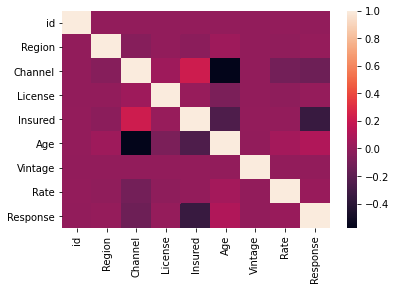

In [19]:
corr = data.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

### Correlation Matrix & Heatmap

**Atributos com uma correlação fraca positiva:**
    
Age vs Response: 0.11
    
**Atributos com uma correlação moderada negativa:**

Insured vs Response: -0.34
Age vs Insured  :-0.25

**Questões:**
- Quais atributos afetam nossa variável alvo (Response)?

- Existem atributos com alta correlação entre eles?

- Como podemos aprofundar para entender as correlações?

**Resumo:**

Existe uma **correlação negativa** entre os atributos Insured e Response  

- Faz sentido pois quem já possui um seguro pode não se interessar em adquirir um novo 

Há tambem **correlação negativa** entre os atributos Age vs Insured 

- Faz sentido já que pessoas mais velhas pegam mais por um seguro saúde.


#### Calculando distribuições dos atributos

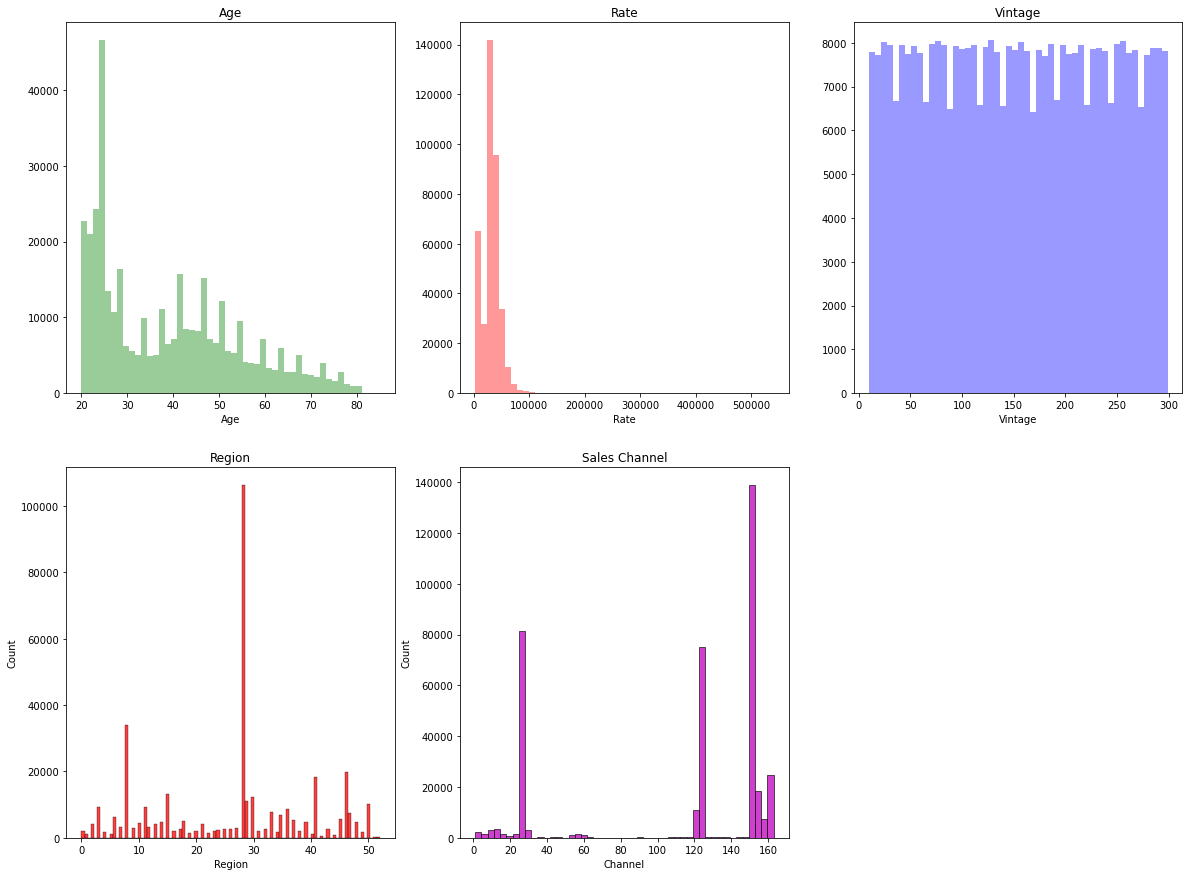

In [21]:
fig, ax = plt.subplots(figsize=(20,15))

plt.subplot(2,3,1)
plt.title('Age')
ax=sns.distplot(data.Age, kde=False, color="g");

plt.subplot(2,3,2)
plt.title('Rate')
ax=sns.distplot(data.Rate, kde=False, color="r");

plt.subplot(2,3,3)
plt.title('Vintage')
ax=sns.distplot(data.Vintage, kde=False, color="b");

plt.subplot(2,3,4)
plt.title('Region')
ax=sns.histplot(data.Region, kde=False, color="r");

plt.subplot(2,3,5)
plt.title('Sales Channel')
sns.histplot(data.Channel, kde=False, color="m");

## Distribuições (Age - Rate - Vintage)
***
**Summary:** Examinando a distribuição de alguns atributos do conjunto de dados:
 - **Age** - Existe um pico de clientes com idade de 25 anos  e um outro pico na faixa entre 40 e 50 anos, mas a maioria dos clientes se concentram na faixa de idade entre 20 e 30 anos
 - **Rate** - A taxa anual paga mostra um pico de clientes que pagam em torno de 50.000 e a maior concentração está abaixo de 100.000
 - **Vintage** - A distribuição de quanto tempo a pessoa está na empresa parece não variar
 - **Region** - Uma das regiões apresenta alta concentração de clientes
 - **Sales Channel**- Três dos canais de vendas são os que apresentam maior concentração de clientes
 
**Questões**
- Pessoas jovens e de meia idade tem maior interesse em seguro saúde? 
- O valor anual pago por pessoas idosas é mais elevado por isso o menor interesse?
- Quanto maior o tempo associado do cliente a empresa a probabilidade de adquirir um seguro de automóvel aumenta?
- Regiões que possuem concentração de cliente alta trabalham com canais de vendas mais efetivos?
- Os canais de venda mais efetivos utlizam mídias de divulgação que impactam pessoas mais jovens?

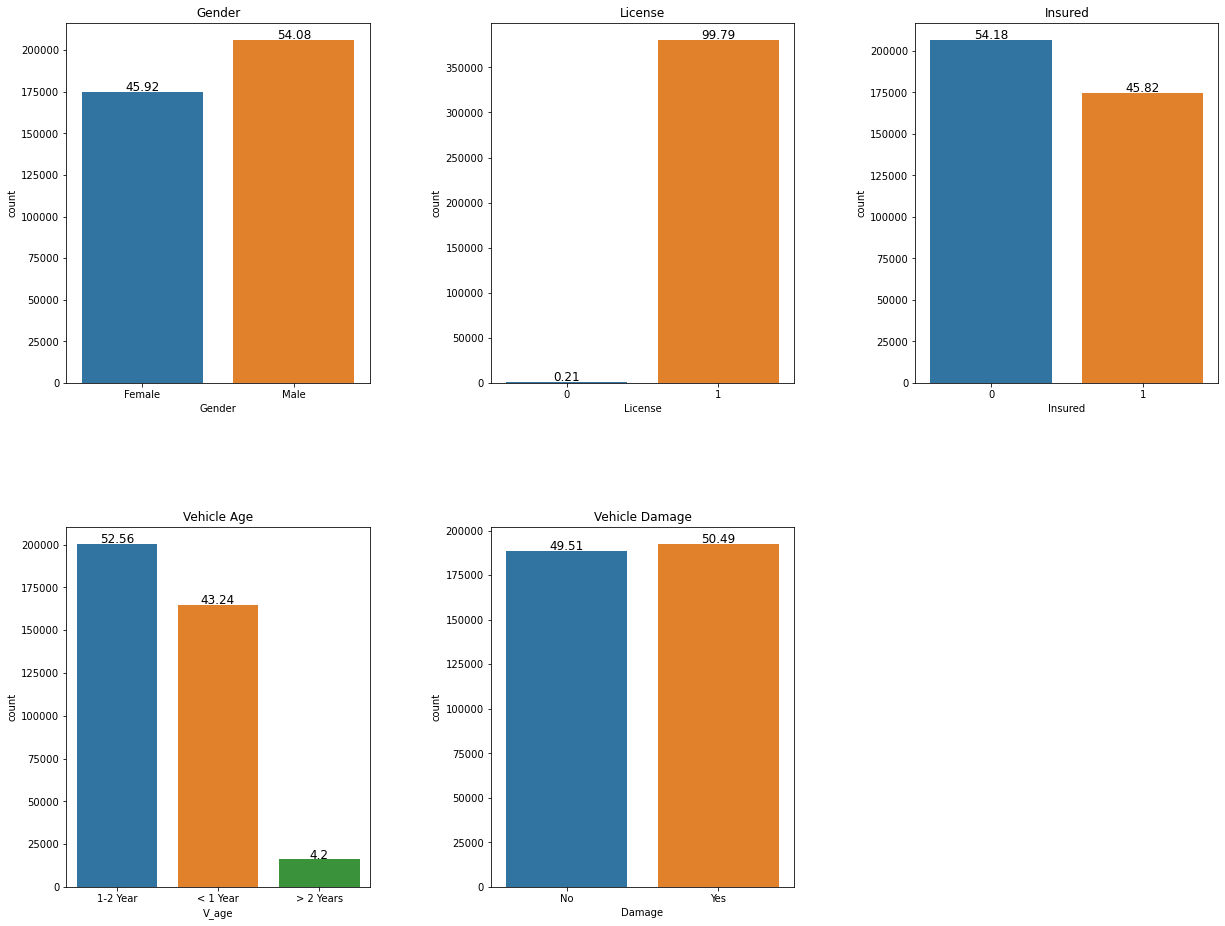

In [22]:
fig, ax = plt.subplots(figsize=(20,15))

plt.subplot(2,3,1)
plt.title('Gender')
ax=sns.countplot(data=data,x='Gender')
for i in ax.patches:
    ax.annotate((i.get_height()/len(data)*100).round(2),
             (i.get_x() + i.get_width()/2,i.get_height()),
             ha='center',va='baseline',fontsize=12,color='black',
             xytext=(0,1),textcoords='offset points') 
    
  
plt.subplot(2,3,2)
plt.title('License')
ax=sns.countplot(data=data,x='License')
for i in ax.patches:
    ax.annotate((i.get_height()/len(data)*100).round(2),
             (i.get_x() + i.get_width()/2,i.get_height()),
             ha='center',va='baseline',fontsize=12,color='black',
             xytext=(0,1),textcoords='offset points')
  
  
plt.subplot(2,3,3)
plt.title('Insured')

ax =sns.countplot(data=data,x='Insured')
for i in ax.patches:
    ax.annotate((i.get_height()/len(data)*100).round(2),
             (i.get_x() + i.get_width()/2,i.get_height()),
             ha='center',va='baseline',fontsize=12,color='black',
             xytext=(0,1),textcoords='offset points')
    
plt.subplot(2,3,4)
plt.title('Vehicle Age')
ax =sns.countplot(data=data,x='V_age')
for i in ax.patches:
    ax.annotate((i.get_height()/len(data)*100).round(2),
             (i.get_x() + i.get_width()/2,i.get_height()),
             ha='center',va='baseline',fontsize=12,color='black',
             xytext=(0,1),textcoords='offset points')
    
    
plt.subplot(2,3,5)
plt.title('Vehicle Damage')
ax =sns.countplot(data=data,x='Damage')
for i in ax.patches:
    ax.annotate((i.get_height()/len(data)*100).round(2),
             (i.get_x() + i.get_width()/2,i.get_height()),
             ha='center',va='baseline',fontsize=12,color='black',
             xytext=(0,1),textcoords='offset points')
    
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 

## Distribuições (Gender - License - Insured - V_age - Demage)
***
**Summary:** Examinando a distribuição de alguns atributos categóricos do conjunto de dados:

 - **Gender**- A quantidade de clientes homens e mulheres é quase igual
 - **License** - Quase todos os clientes possuem habilitação
 - **Inured** - Metade dos clientes não possuem seguro de automóvel
 - **V_age** - 95% dos clientes possuem veículos com menos de 2 anos
 - **Demage** - Um pouco mais da metade dos clientes já sofreu algum dano no veículo anteriormente
 
**Questões**
- Pessoas que já sofreram algum dano são mais propensas a adquirir um seguro de automóvel?
- Quem possui veículos mais novos são menos propensas a aquirir um seguro?
- Mulheres são mais interessadas em seguro saúde do que em seguro de automóvel?

#### Verificando o Resposta em relação ao Gênero

In [23]:
pd.crosstab(index = data['Response'], columns = data['Gender'], normalize = 'index')

Gender,Female,Male
Response,,
0,0.469006,0.530994
1,0.389317,0.610683


In [24]:
data[data['Response'] == 0]['Gender'].value_counts()

Male      177564
Female    156835
Name: Gender, dtype: int64

In [25]:
data[data['Response'] == 1]['Gender'].value_counts()

Male      28525
Female    18185
Name: Gender, dtype: int64

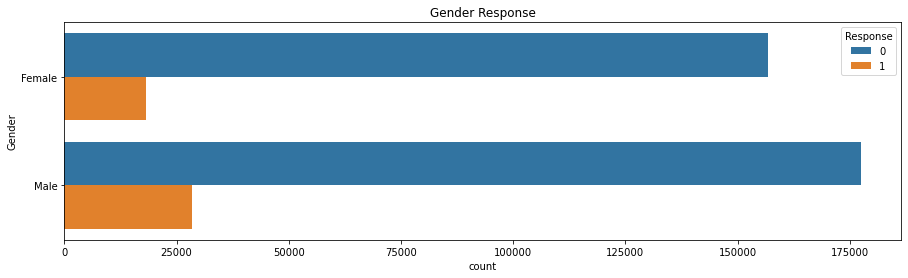

In [27]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='Gender',hue='Response',data=data).set_title('Gender Response');

## Age VS. Response

**Resumo**:
- Homens possuem maior interesse em adquirir um seguro de automóvel.


#### Verificando o Resposta em relação a Idade.

In [28]:
data['Range_age']=data['Age'].apply(lambda x: '<26' if x<=26 else '<40' if x>26 and x<40 else '<60' if x>=40 and x<60 else 'maior_60')

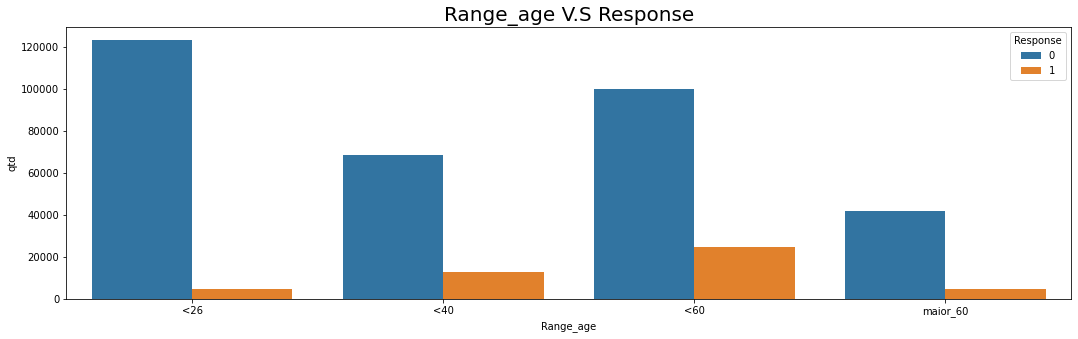

In [29]:
plt.figure(figsize = (18, 5))
plt.title('Range_age V.S Response',fontsize=20)
ax=data[['Range_age','Response']].groupby(['Range_age','Response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=ax,x='Range_age',y='qtd',hue='Response')

In [30]:
pd.crosstab(index = data['Gender'], columns = data['Range_age'], normalize='columns')

Range_age,<26,<40,<60,maior_60
Gender,,,,
Female,0.559239,0.481097,0.366672,0.394587
Male,0.440761,0.518903,0.633328,0.605413


##  Age VS. Response

**Resumo:** Informação sobre a idade dos clientes
- Podemos ver que clientes mais jovens não estão interessados no seguro do veículo

**Insights**
- Clientes jovens tem menor interesse em adquirir um seguro de automóvel e isso faz sentido, já que 
  o valor do seguro é maior devido ao aumento no risco de acidentes.
- A maioria dos clientes jovens são mulheres

#### Verificando o Resposta em relação a Danos no Veículo

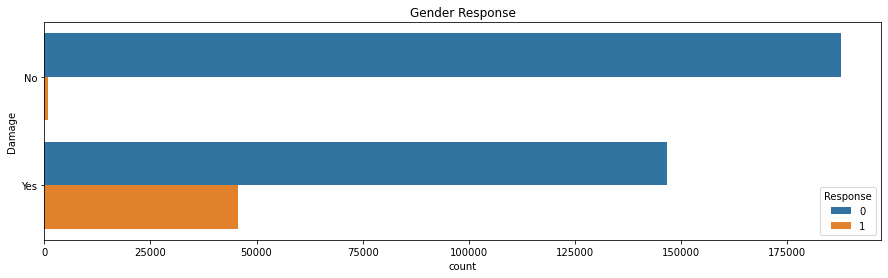

In [32]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='Damage',hue='Response',data=data).set_title('Gender Response');

In [33]:
pd.crosstab(index = data['Gender'], columns = data['Damage'], normalize='columns')

Damage,No,Yes
Gender,,
Female,0.505337,0.414031
Male,0.494663,0.585969


In [34]:
pd.crosstab(index = data['Range_age'], columns = data['Damage'], normalize='columns')

Damage,No,Yes
Range_age,,
<26,0.469713,0.204804
<40,0.226020,0.201478
<60,0.208653,0.444398
maior_60,0.095614,0.149319


## Damage VS. Response

**Resumo:** Informação sobre danos no veículo
- Quem já sofreu algum dano no veículo é mais propenso a adquirir um seguro de automóvel

**Insights**
- Homens possuem mais danos em veículos do que mulheres
- Pessoas mais jovens são as que sofrem mais danos no veículo

#### Verificando o Resposta em relação ao Idade do Veiculo

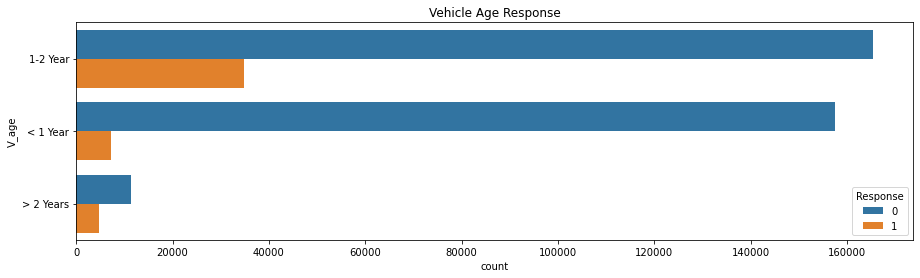

In [35]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='V_age',hue='Response',data=data).set_title('Vehicle Age Response');

In [36]:
pd.crosstab(index = data['V_age'], columns = data['Damage'], normalize='columns')

Damage,No,Yes
V_age,,
1-2 Year,0.382048,0.666405
< 1 Year,0.617872,0.250482
> 2 Years,0.000079,0.083113


In [37]:
pd.crosstab(index = data['V_age'], columns = data['Range_age'], normalize='columns')

Range_age,<26,<40,<60,maior_60
V_age,,,,
1-2 Year,0.028226,0.500123,0.919603,0.879653
< 1 Year,0.971478,0.488135,0.004396,0.002288
> 2 Years,0.000297,0.011742,0.076001,0.118060


##  V_Age VS. Response

**Resumo**: Informações idade do veiculo
- A maioria dos veículos tem menos de 1 ano de idade
- Veículos entre 1 e 2 anos de idade tem uma taxa de resposta maior de
  interesse em adquirir seguros
  
**Insights**
- Veículos entre 1 e 2 anos de idade tem mais danos
- Jovens possuem veículos com menos de 1 anos

#### Verificando o Resposta em relação a Habilitação

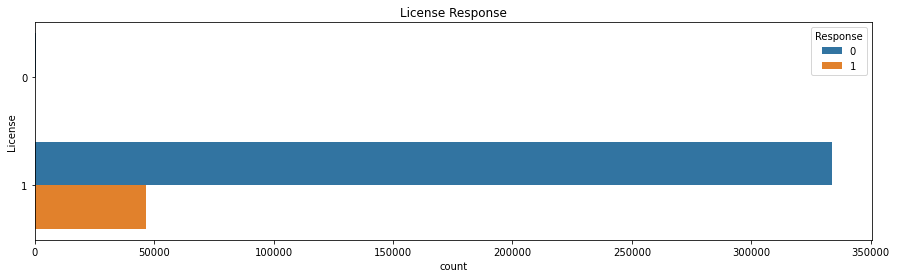

In [38]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='License',hue='Response',data=data).set_title('License Response');

In [39]:
data[['License','Age']].groupby('License').mean()

,Age
License,
0,65.604680
1,38.765399


##  License VS. Response

**Resumo**: Informações sobre habilitação
- A maioria dos clientes possui habilitação

**Insights**
- Os clientes que não possuem habilitação tem em média idade acima dos 60 anos


#### Verificando o Resposta em relação a Previamente Assegurado

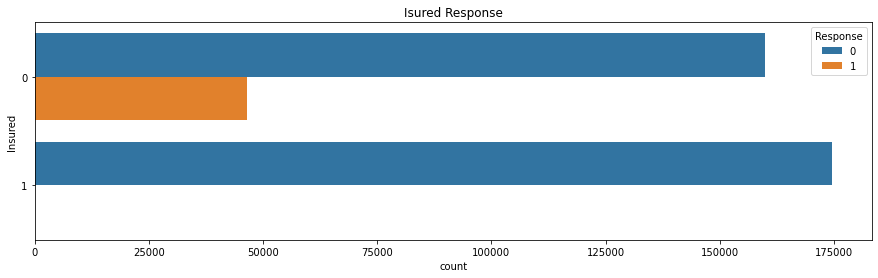

In [40]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='Insured',hue='Response',data=data).set_title('Isured Response');

In [41]:
pd.crosstab(index = data['Insured'], columns = data['V_age'], normalize='columns')

V_age,1-2 Year,< 1 Year,> 2 Years
Insured,,,
0,0.67389,0.336976,0.997126
1,0.32611,0.663024,0.002874


##  Insured VS. Response

**Resumo**: Informações sobre possuir um seguro de automóvel.
- A maioria dos clientes que possuem um seguro não estão interessados em adquirir um novo seguro de automóvel

**Insights**
- Quanto mais jovem o veículo maior é a probabilidade de possuir seguro
- Os clientes que possuem seguro saúde estão há pouco tempo associados e por isso possuem um interesse menor?

#### Verificando o Resposta em relação a Taxa Anual

In [46]:
data['Range_rate']=data['Rate'].apply(lambda x: 'Bronze' if x< 50000 else 'Prata' if x>50000 and x<100000 else 'Ouro')

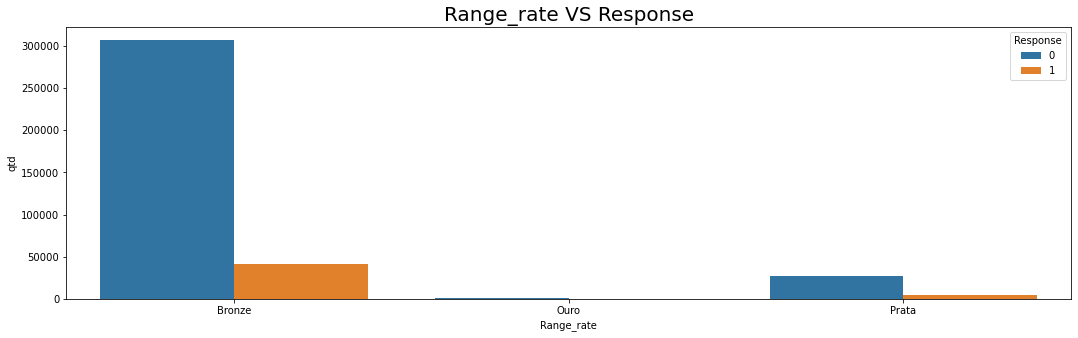

In [47]:
plt.figure(figsize = (18, 5))
plt.title('Range_rate VS Response',fontsize=20)
ax=data[['Range_rate','Response']].groupby(['Range_rate','Response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=ax,x='Range_rate',y='qtd',hue='Response')

In [48]:
pd.crosstab(index = data['Response'], columns = [data['Insured'], data['Range_rate']],normalize = 'columns')

Insured            0                             1               
Range_rate    Bronze      Ouro     Prata    Bronze Ouro     Prata
Response                                                         
0           0.777185  0.719818  0.749921  0.999074  1.0  0.999353
1           0.222815  0.280182  0.250079  0.000926  0.0  0.000647

## Rate VS. Response

**Resumo**: Informações sobre Taxa anual.
- A maioria dos clientes interessados em adquirir um seguro de automóvel paga anualmente até 50.000 por um seguro saúde

**Questões**
- Clientes que estão na classificação bronze possuem menor interesse em adquirir um seguro de automóvel?


#### Verificando o Resposta em relação a Canal de Vendas

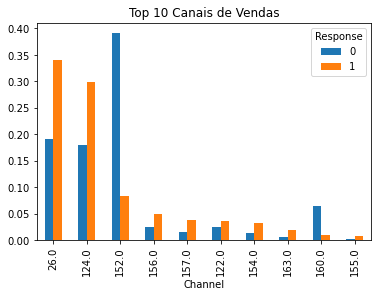

In [51]:
pd.crosstab(index = data['Channel'], columns = data['Response'], normalize='columns').sort_values(1,ascending = False).head(10).plot(kind='bar');
plt.title('Top 10 Canais de Vendas');

In [52]:
pd.crosstab(index = [data['Channel'], data['Range_age']],columns = data['Response'], normalize='columns').sort_values(1,ascending = False).head(10)

Response                  0         1
Channel Range_age                    
26.0    <60        0.109028  0.235667
124.0   <60        0.103673  0.167416
        <40        0.036878  0.098459
152.0   <26        0.277103  0.054956
26.0    <40        0.020063  0.050246
        maior_60   0.051370  0.047313
152.0   <40        0.100228  0.025369
156.0   <40        0.010598  0.025348
124.0   maior_60   0.032309  0.022693
122.0   <60        0.011214  0.019011

## Sales Chanel VS. Response

**Resumo**: Informações sobre Canal de Vendas.
- Os canais de vendas que atraem o maior número de clientes são 152, 26 e 124
- Apesar do canal 152 atrair mais clientes para seguro saúde, ele é o que possui o menor
  número de clientes interessados em seguro de veículos

**Insights**
- Os clientes dos canais de vendas com menor interesse em seguro de automóveis são jovens
- Os canais com maior número de clientes utilizam mídias direcionadas ao público jovem?



#### Verificando o Resposta em relação a Codigo da Região

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '20'),
 Text(21, 0, '21'),
 Text(22, 0, '22'),
 Text(23, 0, '23'),
 Text(24, 0, '24'),
 Text(25, 0, '25'),
 Text(26, 0, '26'),
 Text(27, 0, '27'),
 Text(28, 0, '28'),
 Text(29, 0, '29'),
 Text(30, 0, '30'),
 Text(31, 0, '31'),
 Text(32, 0, '32'),
 Text(33, 0, '33'),
 Text(34, 0, '34'),
 Text(35, 0, '35'),
 Text(36, 0, '36'),
 Text(37, 0, '37'),
 Text(38, 0, '38'),
 Text(39, 0, '39'),
 Text(40, 0, '40'),
 Text(41, 0, '41'),
 Text(42, 0, '42'),
 Text(43, 0, '43'),
 Text(44, 0, '44'),
 Text(45, 0, '45'),
 Text(46, 0, '46'),
 Text(47, 0, '47'),
 Text(48, 0, '48'),
 Text(49, 0, '49'),
 Text(50, 0, '50'),


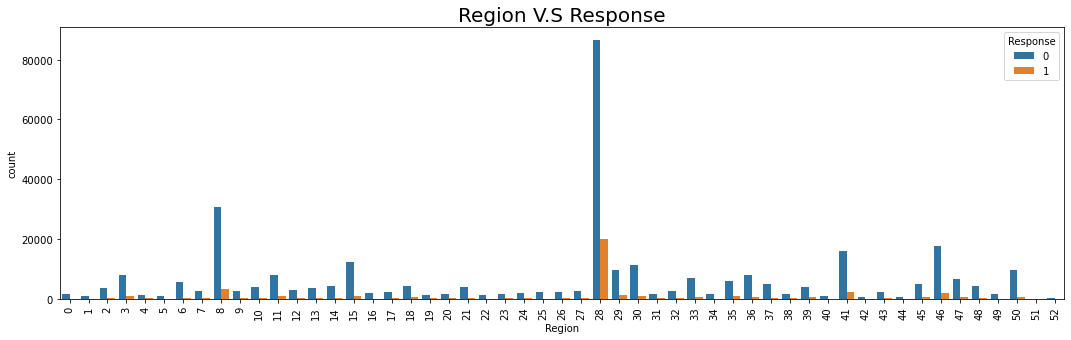

In [53]:
plt.figure(figsize = (18, 5))
plt.title('Region V.S Response',fontsize=20)
ax=sns.countplot(data['Region'], hue = data['Response'])
ax.set_xticklabels(ax.get_xticks(), rotation = 90) 

In [54]:
pd.crosstab(index = data['Region'], columns = data['Response'], normalize = 'index').sort_values(1,ascending = False).head(5)

Response,0,1
Region,,
38.0,0.807996,0.192004
28.0,0.812837,0.187163
19.0,0.837134,0.162866
4.0,0.841755,0.158245
23.0,0.846939,0.153061


In [55]:
data[['Region','Channel',]].groupby('Region').count().sort_values(by='Channel',ascending = False).head()

,Channel
Region,
28.0,106415
8.0,33877
46.0,19749
41.0,18263
15.0,13308


In [56]:
pd.crosstab(index = data['Region'], columns = data['Range_age'], normalize = 'index')

Range_age,<26,<40,<60,maior_60
Region,,,,
0.0,0.009896,0.217219,0.609599,0.163286
1.0,0.132937,0.197421,0.516865,0.152778
2.0,0.602526,0.189450,0.159733,0.048291
3.0,0.358015,0.262674,0.283321,0.095990
4.0,0.285952,0.270405,0.347585,0.096058
5.0,0.515246,0.207193,0.207975,0.069586
6.0,0.607006,0.220064,0.133121,0.039809
7.0,0.271729,0.201586,0.403782,0.122903
8.0,0.368451,0.177111,0.331729,0.122709


## Region VS. Response

**Resumo**: Informações sobre Region.
- A Região com o maior número de clientes é 28, mas a região 38 é a que possui mais clientes interessados

**Insights**
- As Regiões com maior número de clientes utlizam mais canais de venda
- As Regiões que possuem maior número de clientes interessados utilizam canais de venda mais efetivos


In [57]:
my_report = sv.analyze(data,"Response")
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
